In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
DATA_PATH = Path("C:/Users/prate/Downloads/fraudTest.csv/fraudTest.csv")
df = pd.read_csv(DATA_PATH)

In [3]:
df = df.drop(columns=["Unnamed: 0"])
df.shape

(555719, 22)

In [4]:
df = df[
    [
        "cc_num",
        "category",
        "amt",
        "unix_time",
        "lat",
        "long",
        "merch_lat",
        "merch_long",
        "is_fraud"
    ]
]

In [5]:
df = df.sort_values(by=["cc_num", "unix_time"])
df.reset_index(drop=True, inplace=True)

In [6]:
df["txn_count_cust"] = df.groupby("cc_num").cumcount()

In [7]:
df["cust_avg_amt"] = (
    df.groupby("cc_num")["amt"].transform("mean")
)

In [8]:
df["amt_deviation"] = (df["amt"] - df["cust_avg_amt"]).abs()

In [9]:
df["cust_category_count"] = (
    df.groupby(["cc_num", "category"]).cumcount()
)

In [10]:
from math import radians, sin, cos, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*asin(sqrt(a))
    return 6371 * c

df["distance_from_home"] = df.apply(
    lambda x: haversine(
        x["lat"], x["long"],
        x["merch_lat"], x["merch_long"]
    ),
    axis=1
)

In [11]:
df = df.drop(
    columns=[
        "cust_avg_amt",
        "lat", "long", "merch_lat", "merch_long"
    ]
)

In [12]:
df = pd.get_dummies(df, columns=["category"], drop_first=True)

In [13]:
y = df["is_fraud"]
X = df.drop(columns=["is_fraud", "cc_num"])

In [14]:
# Train on NORMAL only
X_train = X[y == 0].sample(frac=0.8, random_state=42)

# Validate on mixed data
X_val = X.drop(X_train.index)
y_val = y.loc[X_val.index].values

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## Isolation forest

In [16]:
iso = IsolationForest(
    n_estimators=300,
    contamination=0.01,
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train_scaled)

IsolationForest(contamination=0.01, n_estimators=300, n_jobs=-1,
                random_state=42)

In [17]:
iso_scores = -iso.decision_function(X_val_scaled)

threshold = np.percentile(iso_scores, 98)
y_pred_iso = (iso_scores >= threshold).astype(int)

(
    precision_score(y_val, y_pred_iso),
    recall_score(y_val, y_pred_iso),
    f1_score(y_val, y_pred_iso),
    roc_auc_score(y_val, iso_scores)
)

(0.43844109831709477,
 0.46153846153846156,
 0.44969339086986143,
 0.8855216300657297)

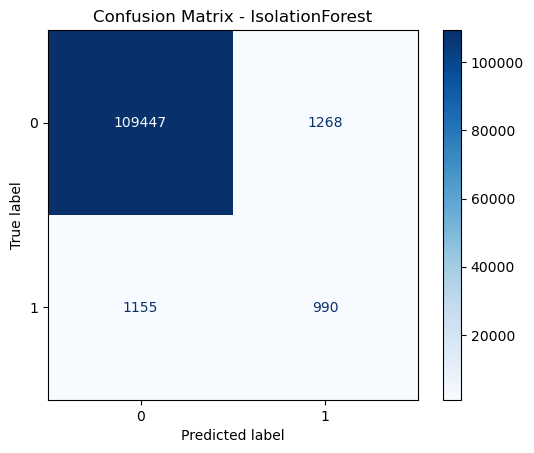

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm_oc = confusion_matrix(y_val, y_pred_iso)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_oc)
disp.plot(cmap="Blues")

plt.title("Confusion Matrix - IsolationForest")
plt.show()

## Autoencoder

In [19]:
input_dim = X_train_scaled.shape[1]

inp = Input(shape=(input_dim,))
enc = Dense(32, activation="relu")(inp)
enc = Dense(16, activation="relu")(enc)
dec = Dense(32, activation="relu")(enc)
out = Dense(input_dim)(dec)

ae = Model(inp, out)
ae.compile(optimizer="adam", loss="mse")

In [20]:
ae.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=40,
    batch_size=256,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5)],
    verbose=1
)

Epoch 1/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2649 - val_loss: 0.0095
Epoch 2/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0081 - val_loss: 0.0047
Epoch 3/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 4/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 5/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 6/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 7/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 9.0524e-04
Epoch 8/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0010 - val_loss: 7.2188e-04
Epoch 9/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.1664e-04 - val_loss: 6.4937e-04
Epoch 10/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0011 - val_loss: 6.6437e-04
Epoch 11/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.7504e-04 - val_loss: 0.0014
Epoch 

In [21]:
X_val_pred = ae.predict(X_val_scaled)
recon_error = np.mean((X_val_scaled - X_val_pred)**2, axis=1)

threshold = np.percentile(recon_error, 98)
y_pred_ae = (recon_error >= threshold).astype(int)

(
    precision_score(y_val, y_pred_ae),
    recall_score(y_val, y_pred_ae),
    f1_score(y_val, y_pred_ae),
    roc_auc_score(y_val, recon_error)
)

3527/3527 ━━━━━━━━━━━━━━━━━━━━ 3s 941us/step


(0.13950398582816653,
 0.14685314685314685,
 0.14308426073131955,
 0.8483219446557748)

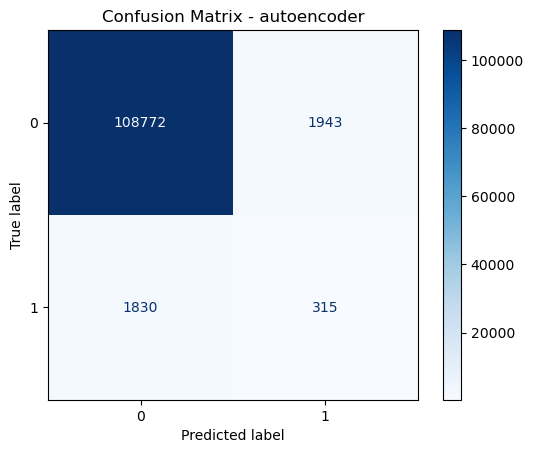

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm_oc = confusion_matrix(y_val, y_pred_ae)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_oc)
disp.plot(cmap="Blues")

plt.title("Confusion Matrix - autoencoder")
plt.show()

In [23]:
y_pred_or = ((y_pred_iso == 1) | (y_pred_ae == 1)).astype(int)

(
    precision_score(y_val, y_pred_or),
    recall_score(y_val, y_pred_or),
    f1_score(y_val, y_pred_or),
    roc_auc_score(y_val, recon_error)
)

(0.27834561445210365,
 0.5459207459207459,
 0.36870277078085645,
 0.8483219446557748)

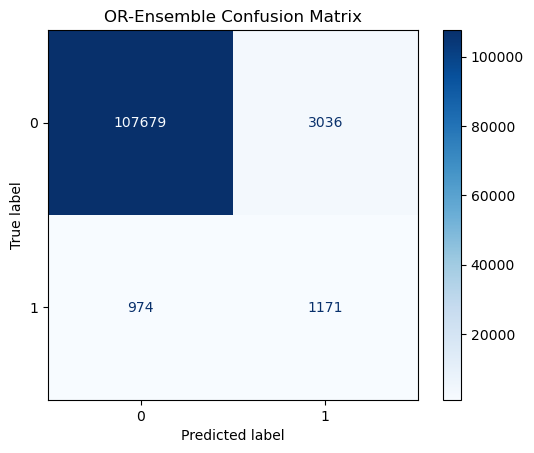

In [24]:
cm = confusion_matrix(y_val, y_pred_or)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("OR-Ensemble Confusion Matrix")
plt.show()

Point-based anomaly detection failed because fraud was contextual. After introducing behavioral features capturing deviation from customer-specific baselines, recall improved significantly while maintaining low latency

In [25]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

score_scaler = MinMaxScaler()

iso_norm = score_scaler.fit_transform(
    iso_scores.reshape(-1, 1)
).ravel()

ae_norm = score_scaler.fit_transform(
    recon_error.reshape(-1, 1)
).ravel()

In [26]:
def business_cost(y_true, y_pred, fp_cost=10, fn_cost=1):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return fp_cost * fp + fn_cost * fn

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

weight_grid = np.round(np.arange(0.0, 1.01, 0.1), 2)
threshold_percentiles = np.arange(95.0, 99.91, 0.01)

best_result = {
    "cost": np.inf,
    "w_iso": None,
    "w_ae": None,
    "threshold": None,
    "precision": None,
    "recall": None,
    "f1": None
}

for w_iso in weight_grid:
    w_ae = 1.0 - w_iso
    ensemble_score = w_iso * iso_norm + w_ae * ae_norm

    thresholds = np.percentile(ensemble_score, threshold_percentiles)

    for t in thresholds:
        y_pred = (ensemble_score >= t).astype(int)
        cost = business_cost(y_val, y_pred)

        if cost < best_result["cost"]:
            best_result.update({
                "cost": cost,
                "w_iso": w_iso,
                "w_ae": w_ae,
                "threshold": t,
                "precision": precision_score(y_val, y_pred, zero_division=0),
                "recall": recall_score(y_val, y_pred, zero_division=0),
                "f1": f1_score(y_val, y_pred, zero_division=0)
            })

In [28]:
best_result

{'cost': 2109,
 'w_iso': 0.0,
 'w_ae': 1.0,
 'threshold': 0.0444925506012882,
 'precision': 0.9380530973451328,
 'recall': 0.04941724941724942,
 'f1': 0.09388839681133747}

In [29]:
final_score = (
    best_result["w_iso"] * iso_norm +
    best_result["w_ae"] * ae_norm
)

y_pred_cost = (final_score >= best_result["threshold"]).astype(int)

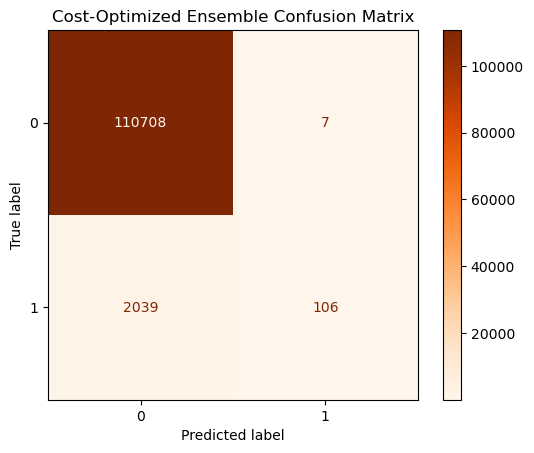

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_cost)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Oranges")
plt.title("Cost-Optimized Ensemble Confusion Matrix")
plt.show()

In [31]:
fraud_probability = MinMaxScaler().fit_transform(
    final_score.reshape(-1, 1)
).ravel()

In [32]:
def generate_reason(row):
    reasons = []

    if row["amt_deviation"] > row["amt_deviation"].quantile(0.95):
        reasons.append("Transaction amount deviates significantly from customer’s usual spending")

    if row["txn_count_cust"] > row["txn_count_cust"].quantile(0.95):
        reasons.append("High transaction velocity for this customer")

    if row["cust_category_count"] == 0:
        reasons.append("Merchant category not previously seen for this customer")

    if row["distance_from_home"] > row["distance_from_home"].quantile(0.95):
        reasons.append("Transaction location far from customer’s typical location")

    return reasons[:3]  # limit for API

## API Deployment

In [33]:
AVAILABLE_MODELS = {
    "isolation_forest": "Isolation Forest (baseline, fast)",
    "autoencoder": "Autoencoder (default, balanced)",
    "or_ensemble": "Isolation Forest + Autoencoder (high recall)"
}

Default model for production inference: Autoencoder
Alternative high-recall option: OR-Ensemble
Isolation Forest retained as a fast baseline
Cost-optimized ensemble rejected due to unacceptable recall

In [34]:
import os

os.makedirs("artifacts/models", exist_ok=True)
os.makedirs("artifacts/config", exist_ok=True)

In [35]:
import joblib

joblib.dump(iso, "artifacts/models/isolation_forest.pkl")

['artifacts/models/isolation_forest.pkl']

In [36]:
ae.save("artifacts/models/autoencoder.keras")

In [37]:
joblib.dump(scaler, "artifacts/models/scaler.pkl")

['artifacts/models/scaler.pkl']

In [38]:
import json

or_ensemble_config = {
    "type": "or_ensemble",
    "models": ["isolation_forest", "autoencoder"],
    "description": "High recall mode using logical OR"
}

with open("artifacts/config/or_ensemble.json", "w") as f:
    json.dump(or_ensemble_config, f, indent=4)

In [39]:
model_registry = {
    "default_model": "autoencoder",
    "available_models": {
        "isolation_forest": {
            "path": "artifacts/models/isolation_forest.pkl",
            "type": "sklearn",
            "description": "Fast baseline model"
        },
        "autoencoder": {
            "path": "artifacts/models/autoencoder",
            "type": "tensorflow",
            "description": "Balanced default fraud detector"
        },
        "or_ensemble": {
            "path": "artifacts/config/or_ensemble.json",
            "type": "ensemble",
            "description": "High recall fraud detection mode"
        }
    }
}

with open("artifacts/config/model_registry.json", "w") as f:
    json.dump(model_registry, f, indent=4)

In [40]:
!tree artifacts /f

Folder PATH listing for volume Prateeek
Volume serial number is 8E52-0FE4
C:\USERS\PRATE\FRAUD_DETECTION_PROJECT\ARTIFACTS
+---config
¦       model_registry.json
¦       or_ensemble.json
¦       
+---models
        autoencoder.keras
        isolation_forest.pkl
        scaler.pkl
        


In [41]:
import os
print(os.getcwd())

C:\Users\prate\fraud_detection_project


In [42]:
import os

print(os.listdir("artifacts/models"))
print(os.listdir("artifacts/config"))

['autoencoder.keras', 'isolation_forest.pkl', 'scaler.pkl']
['model_registry.json', 'or_ensemble.json']


In [43]:
pip install notebook

  Obtaining dependency information for anyio<4,>=3.1.0 from https://files.pythonhosted.org/packages/19/24/44299477fe7dcc9cb58d0a57d5a7588d6af2ff403fdd2d47a246c91a3246/anyio-3.7.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/80.9 kB ? eta -:--:--
   ------------------------------ --------- 61.4/80.9 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 80.9/80.9 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: anyio
    Found existing installation: anyio 4.12.1
    Uninstalling anyio-4.12.1:
      Successfully uninstalled anyio-4.12.1
Note: you may need to restart the kernel to use updated packages.


In [44]:
import json
import joblib
import tensorflow as tf
from pathlib import Path

BASE_DIR = Path("artifacts")

def load_model_registry():
    with open(BASE_DIR / "config" / "model_registry.json") as f:
        return json.load(f)

def load_models():
    registry = load_model_registry()
    models = {}

    for model_name, meta in registry["available_models"].items():
        model_type = meta["type"]
        model_path = BASE_DIR / meta["path"]

        if model_type == "sklearn":
            models[model_name] = joblib.load(model_path)

        elif model_type == "tensorflow":
            models[model_name] = tf.keras.models.load_model(model_path)

        elif model_type == "ensemble":
            with open(model_path) as f:
                models[model_name] = json.load(f)

    return models, registry

def select_model(model_name=None):
    models, registry = load_models()

    if model_name is None:
        model_name = registry["default_model"]

    if model_name not in models:
        raise ValueError(f"Model '{model_name}' is not available")

    return model_name, models[model_name], models

In [45]:
import sys
import os
project_root = os.path.abspath("fraud_detection_project")
sys.path.append(project_root)

from utils.model_loader import select_model

In [46]:
import utils.model_loader as ml
print(dir(ml))


['ARTIFACTS_DIR', 'BASE_DIR', 'PROJECT_ROOT', 'Path', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'joblib', 'json', 'load_model_registry', 'load_models', 'select_model', 'tf']


In [47]:
import os

def show_tree(start_path, indent=""):
    for item in os.listdir(start_path):
        path = os.path.join(start_path, item)
        print(indent + "|-- " + item)
        if os.path.isdir(path):
            show_tree(path, indent + "    ")

show_tree(r"C:\Users\prate\fraud_detection_project")



|-- .ipynb_checkpoints
    |-- npst1-checkpoint.ipynb
|-- app.py
|-- artifacts
    |-- config
        |-- model_registry.json
        |-- or_ensemble.json
    |-- models
        |-- autoencoder.keras
        |-- isolation_forest.pkl
        |-- scaler.pkl
|-- Fraud Detection.ipynb
|-- New folder
|-- New Text Document.txt
|-- npst1.ipynb
|-- scaler.joblib
|-- utils
    |-- inference.py
    |-- model_loader.py
    |-- New Text Document.txt
    |-- reasoning.py
    |-- __init__.py
    |-- __pycache__
        |-- inference.cpython-311.pyc
        |-- model_loader.cpython-311.pyc
        |-- reasoning.cpython-311.pyc
        |-- __init__.cpython-311.pyc
|-- __pycache__
    |-- app.cpython-311.pyc


In [48]:
from utils.model_loader import select_model

In [53]:
from utils.reasoning import generate_reasoning

sample_features = {
    "amt_deviation": 8200,
    "txn_count_cust": 14,
    "cust_category_count": 0,
    "distance_from_home": 220
}

generate_reasoning(sample_features)


['The transaction amount is very different from what the customer usually spends.',
 'There have been many transactions from this customer in a short period of time.',
 'The customer has not made purchases in this type of store before.']

In [50]:
pip install fastapi uvicorn pydantic


Note: you may need to restart the kernel to use updated packages.


In [ ]:
!uvicorn app:app


In [2]:
!tree  /f

Folder PATH listing for volume Prateeek
Volume serial number is 8E52-0FE4
C:.
¦   app.py
¦   Fraud Detection.ipynb
¦   New Text Document.txt
¦   npst1.ipynb
¦   scaler.joblib
¦   
+---.ipynb_checkpoints
¦       npst1-checkpoint.ipynb
¦       
+---artifacts
¦   +---config
¦   ¦       model_registry.json
¦   ¦       or_ensemble.json
¦   ¦       
¦   +---models
¦           autoencoder.keras
¦           isolation_forest.pkl
¦           scaler.pkl
¦           
+---New folder
+---utils
¦   ¦   inference.py
¦   ¦   model_loader.py
¦   ¦   New Text Document.txt
¦   ¦   reasoning.py
¦   ¦   __init__.py
¦   ¦   
¦   +---__pycache__
¦           inference.cpython-311.pyc
¦           model_loader.cpython-311.pyc
¦           reasoning.cpython-311.pyc
¦           __init__.cpython-311.pyc
¦           
+---__pycache__
        app.cpython-311.pyc
        


In [3]:
!pip install fastapi uvicorn scikit-learn tensorflow joblib pandas numpy

In [8]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# 1. Feature Engineering (As defined in your script)
def engineer_features(df):
    df = df.sort_values(by=["cc_num", "unix_time"]).reset_index(drop=True)
    df["txn_count_cust"] = df.groupby("cc_num").cumcount()
    df["cust_avg_amt"] = df.groupby("cc_num")["amt"].transform(lambda x: x.expanding().mean().shift())
    df["amt_deviation"] = (df["amt"] - df["cust_avg_amt"]).abs()
    df["cust_category_count"] = df.groupby(["cc_num", "category"]).cumcount()
    
    # Distance calculation
    df["distance_from_home"] = np.sqrt((df["lat"] - df["merch_lat"])**2 + (df["long"] - df["merch_long"])**2) * 111.32
    df.fillna(0, inplace=True)
    
    return df[["amt_deviation", "txn_count_cust", "cust_category_count", "distance_from_home"]]

# 2. Training Pipeline
# Load your full dataset here
# df_raw = pd.read_csv("fraudTest.csv")
X_behavioral = engineer_features(df)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_behavioral)

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_scaled)

# Autoencoder (Natively 4-features)
input_dim = 4 
input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(2, activation="relu")(encoder) # Latent space
decoder = Dense(8, activation="relu")(encoder)
output_layer = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

# Train only on normal data
X_normal = X_scaled[df['is_fraud'] == 0]
autoencoder.fit(X_normal, X_normal, epochs=20, batch_size=256, verbose=0)

# 3. Artifact Export (Overwriting the 19-feature models)
# Ensure these paths match your folder structure
joblib.dump(scaler, "artifacts/models/scaler.pkl")
joblib.dump(iso, "artifacts/models/isolation_forest.pkl")
autoencoder.save("artifacts/models/autoencoder.keras")

print("✅ Success: 4-Feature Models and Scaler saved to artifacts/models/")

NameError: name 'df' is not defined

In [9]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Load your dataset
df = pd.read_csv("C:/Users/prate/Downloads/fraudTest.csv/fraudTest.csv")
df = df.sort_values(by=["cc_num", "unix_time"]).reset_index(drop=True)

In [10]:
# Create behavioral features
df["txn_count_cust"] = df.groupby("cc_num").cumcount()
df["cust_avg_amt"] = df.groupby("cc_num")["amt"].transform(lambda x: x.expanding().mean().shift())
df["amt_deviation"] = (df["amt"] - df["cust_avg_amt"]).abs()
df["cust_category_count"] = df.groupby(["cc_num", "category"]).cumcount()

# Distance calculation (Haversine approximation)
df["distance_from_home"] = np.sqrt((df["lat"] - df["merch_lat"])**2 + (df["long"] - df["merch_long"])**2) * 111.32

# Fill NAs caused by the shift() or first-time transactions
df.fillna(0, inplace=True)

# Select the 4 features for the model
features = ["amt_deviation", "txn_count_cust", "cust_category_count", "distance_from_home"]
X = df[features]

In [11]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_scaled)

# Autoencoder Architecture
input_dim = 4 # Must be 4 to match the features
input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(2, activation="relu")(encoder) 
decoder = Dense(8, activation="relu")(encoder)
output_layer = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

# Train on non-fraudulent data only
X_normal = X_scaled[df['is_fraud'] == 0]
autoencoder.fit(X_normal, X_normal, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.4864
Epoch 2/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0857
Epoch 3/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0718
Epoch 4/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0687
Epoch 5/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0672
Epoch 6/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0657
Epoch 7/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0655
Epoch 8/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0658
Epoch 9/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0645
Epoch 10/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0644
Epoch 11/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0638
Epoch 12/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0632
Epoch 13/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0621
Epoch 14/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0612
Epoch 15/20
2163/2163 ━━━━━━━

In [12]:
# Create the artifacts directory if it doesn't exist
import os
os.makedirs("artifacts/models", exist_ok=True)

# Save the 4-feature versions
joblib.dump(scaler, "artifacts/models/scaler.pkl")
joblib.dump(iso, "artifacts/models/isolation_forest.pkl")
autoencoder.save("artifacts/models/autoencoder.keras")

print("✅ Training complete. 4-feature models saved to artifacts/models/")

✅ Training complete. 4-feature models saved to artifacts/models/


In [14]:
# Returns all rows where column1 equals 1
filtered_df = df[df['is_fraud'] == 0]


In [15]:
# Filters for column1=1 and displays the first 10 rows
print(df[df['is_fraud'] == 1].head(10))


      Unnamed: 0 trans_date_trans_time       cc_num  \
1906      253809   2020-09-22 01:11:51  60487002085   
1907      253900   2020-09-22 02:02:46  60487002085   
1908      256535   2020-09-22 22:39:18  60487002085   
1909      256612   2020-09-22 23:10:08  60487002085   
1910      256714   2020-09-22 23:47:50  60487002085   
1911      256888   2020-09-23 02:56:25  60487002085   
1912      257242   2020-09-23 10:12:36  60487002085   
1913      258083   2020-09-23 22:03:34  60487002085   
2591      263851   2020-09-27 01:54:23  60495593109   
2592      265486   2020-09-27 17:13:05  60495593109   

                                        merchant       category      amt  \
1906              fraud_Moen, Reinger and Murphy    grocery_pos   337.39   
1907                              fraud_Cole PLC    grocery_pos   292.54   
1908                             fraud_Kuhic LLC   shopping_net   995.97   
1909                      fraud_Schmidt and Sons   shopping_net  1062.66   
1910          